### Target classifier

In [1]:
from simpletransformers.language_representation import RepresentationModel
from simpletransformers.classification import MultiLabelClassificationModel
from simpletransformers.config.model_args import ModelArgs
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import torch

In [2]:
# import data
data = pd.read_csv('OneHot_Combined_cln_utf8.tsv', sep='\t')
data = data[data['source']!='SASDG_Hub'] #keep the articles classified by Willem separate as an unseen testing set
# data = data.iloc[-1000:,:] # select a small subset of the data (last 1000 rows)

# import target data
target_df = pd.read_csv('Targets.csv', sep=';')
targets_lst = target_df['target'].unique().tolist()

In [3]:
# function to apply model to text
def classify_sdg(text_lst):
    # see GPU avaialability
    cuda_available = torch.cuda.is_available()
    
    # import model from path (this path is the directory with all the model files)
    sdg_model = MultiLabelClassificationModel(
            "xlnet",
            "outputs/best_model/",   #os.getcwd()+"\\outputs\\best_model\\", #C:\Users\GCM\Desktop\GIT_REPOS\Transformers_simple_wandb_experiments\SASDGHUB\
            num_labels=17,
            use_cuda=cuda_available,
            )
    predictions, raw_outputs = sdg_model.predict(text_lst)
    return(predictions, raw_outputs)

In [4]:
# function to classify targets
def classify_sdg_target(text_lst, 
                        target_data_path='Targets.csv',
                        run_isomap=True, # run faster for multiple samples otherwise (target_data_path required when this is False) (do not use when only one sample)
                        target_embedding_reduced_path=None, # load a previously calculated and reduced embedding for the targets 'outputs/targets_embedded_reduced_gpt2_2D.csv'
                        isomap_dims = 2,
                        isomap_neigbors = 5, # has to be <= len(text_lst) a.k.a n_samples
                        pre_trained_model_type='gpt2', 
                        pre_trained_model_name='gpt2',
                        target_threshold_val=0.5):
    
    # see GPU avaialability
    cuda_available = torch.cuda.is_available()

    # define and load model from hugging face
    model_args = ModelArgs(max_seq_length=1024)
    # model import
    model = RepresentationModel(
        pre_trained_model_type,
        pre_trained_model_name, #gpt2 , gpt2-large
        args=model_args,
    )
    
    # classify sdg of text
    sdg_predictions, sdg_raw_outputs = classify_sdg(text_lst)
    # get embeddings of text
    word_embeddings = model.encode_sentences(text_lst, combine_strategy="mean")
    
    
    # ISOMAP
    if run_isomap==True: 
        # reduce isomap_neigbors to fit the number of samples
        n_samples = len(text_lst)
        if n_samples < isomap_neigbors:
            isomap_neigbors = np.max([1,n_samples-1])
            print('Reduced isomap_n_neigbors to: ', isomap_neigbors)

        # reduce dimensions of embeddings to 2 (can be reduced to higher dimensions)
        isomap = Isomap(n_components=isomap_dims, n_neighbors=isomap_neigbors-1) # input is an array with samples x features
        word_embeddings_transformed = isomap.fit_transform(word_embeddings)

        if target_embedding_reduced_path == None:
            # load pre-calculated embeddings
            target_df = pd.read_csv(target_data_path, sep=';')
            # get sentence list from target data
            target_sentence_list = target_df['text'].tolist()
            # get embeddings of targets
            target_embeddings = model.encode_sentences(target_sentence_list, combine_strategy="mean")
            target_embeddings_transformed = isomap.fit_transform(target_embeddings)

            # add labels to reduced embeddings
            target_trans_df = pd.DataFrame(target_embeddings_transformed)
            target_trans_df['target'] = target_df['target']
            target_trans_df['sdg'] = target_df['sdg']
            target_trans_df.to_csv('outputs/targets_embedded_reduced_'+pre_trained_model_name+'_'+str(isomap_dims)+'D.csv', index=False)

            # define source and target for KNN
            Y = target_trans_df
            X = pd.DataFrame(word_embeddings_transformed)
            idx_ar = np.array(range(0,17), np.int64)
            sdg_label_lst = []
            for row in (np.array(sdg_predictions)==1):
                sdg_label_lst.append(idx_ar[row])
            X['sdg'] = sdg_label_lst
            sdg_prob_lst = []
            for row in sdg_raw_outputs:
                sdg_prob_lst.append(row)
            X['sdg_probability'] = sdg_prob_lst
            
        else:
            # import reduced embedding of targets
            target_trans_df = pd.read_csv(target_embedding_reduced_path, sep=',')
            
            # define source and target for KNN
            Y = target_trans_df
            X = pd.DataFrame(word_embeddings_transformed)
            idx_ar = np.array(range(0,17), np.int64)
            sdg_label_lst = []
            for row in (np.array(sdg_predictions)==1):
                sdg_label_lst.append(idx_ar[row])
            X['sdg'] = sdg_label_lst
            sdg_prob_lst = []
            for row in sdg_raw_outputs:
                sdg_prob_lst.append(row)
            X['sdg_probability'] = sdg_prob_lst

        # plot embeddings if they are 2D
        if isomap_dims ==2:
            trans_df = pd.DataFrame(word_embeddings_transformed)
            trans_df['target'] = target_df['target']
            trans_df['sdg'] = target_df['sdg']
            trans_df.plot.scatter(0,1,c='sdg', colormap='viridis') # colour by sdg
            plt.title('Isomap 2D plot of text embedding')
            plt.show()
    
    else:
        # load pre-calculated embeddings
        target_df = pd.read_csv(target_data_path, sep=';')
        # get sentence list from target data
        target_sentence_list = target_df['text'].tolist()
        # get embeddings of targets
        target_embeddings = model.encode_sentences(target_sentence_list, combine_strategy="mean")
        
        # define source and target for KNN
        Y = pd.DataFrame(target_embeddings)
        Y['target'] = target_df['target']
        Y['sdg'] = target_df['sdg']
        X = pd.DataFrame(word_embeddings)
        idx_ar = np.array(range(0,17), np.int64)
        sdg_label_lst = []
        for row in (np.array(sdg_predictions)==1):
            sdg_label_lst.append(idx_ar[row])
        X['sdg'] = sdg_label_lst
        sdg_prob_lst = []
        for row in sdg_raw_outputs:
            sdg_prob_lst.append(row)
        X['sdg_probability'] = sdg_prob_lst
    
    # use cosine similarity Kmeans variant to classify targets
    # define final results table
    results_df = pd.DataFrame()
    results_df['text'] = text_lst
    results_df['sdg'] = X['sdg']
    results_df['sdg_probability'] = X['sdg_probability']
    # calculate pairwise cosine similarity between targets and text list
    similarity_ar = cosine_similarity(X.loc[:, ~X.columns.isin(['sdg', 'sdg_probability'])], 
                                  Y.loc[:, ~Y.columns.isin(['sdg', 'target'])],
                                 )
    results_df['target_similarity'] = similarity_ar.tolist()
    # select targets on distance sdg and threshold
    targets_ar = np.array(Y['target'])
    targets_full_ar = np.tile(targets_ar, (len(text_lst), 1)) 
    sdg_ar = np.array(Y['sdg'])
    sdg_full_ar = np.tile(sdg_ar, (len(text_lst), 1))
    sdg_select_ar = np.array(X['sdg'])
    
    # select classified SDGs
    sdg_onehot_lst = []
    for i in range(len(sdg_full_ar)):
        isin_ar = np.isin(sdg_full_ar[i], sdg_select_ar[i])
        sdg_onehot_lst.append(isin_ar)
    sdg_onehot_ar = np.vstack(sdg_onehot_lst)
    target_onehot_ar = (similarity_ar>=target_threshold_val)*sdg_onehot_ar
    target_label_lst = (targets_full_ar*target_onehot_ar).tolist()
    results_df['target'] = [[ele for ele in sub if ele != ''] for sub in target_label_lst]
    
    return results_df

In [5]:
# evaluation metrics
# create functions for additional evaluation outputs
def acc_result(true, pred):
    one_hot = MultiLabelBinarizer(classes=targets_lst)
    pred=one_hot.fit_transform(pred)
    true=one_hot.fit_transform(true)
    acc_sum = 0
    for i in range(true.shape[0]):
        acc_sum += sklearn.metrics.accuracy_score(true[i], pred[i])    
    acc = acc_sum/true.shape[0]
    return acc

def f1_macro_result(true, pred):
    one_hot = MultiLabelBinarizer(classes=targets_lst)
    pred=one_hot.fit_transform(pred)
    true=one_hot.fit_transform(true)
    f1 = sklearn.metrics.f1_score(true, pred, average='samples')
    return f1

# def cm_wandb_result(true, pred):
#     # modify labels and fill all combinations to use wand multiclass confusion matrix visually
#     d=true-pred
#     t_d = (d==1)
#     p_d = (d==-1)
#     n_d = (d==0)
#     idx_ar = np.array(range(0,true.shape[1]))
#     idx = np.tile(idx_ar,300).reshape(300,true.shape[1])
#     n_labels = idx[n_d]
#     t_lst = []
#     for row in t_d:
#         if row.sum()==0:
#             t_lst.append(idx_ar)
#         else:
#             t_lst.append(idx_ar[row])
#     p_lst = []
#     for row in p_d:
#         if row.sum()==0:
#             p_lst.append(idx_ar)
#         else:
#             p_lst.append(idx_ar[row])
#     for i in range(len(t_lst)):
#         fill_ar = np.array(list(itertools.product(p_lst[i], t_lst[i])))
#         t_labels = np.append(n_labels,fill_ar[:,0].tolist())
#         p_labels = np.append(n_labels,fill_ar[:,1].tolist())
#     wandb_cm = wandb.plot.confusion_matrix(probs=None, y_true=t_labels, preds=p_labels, class_names=sdg_lst)
#     return wandb_cm

def cm_result(true, pred):
    one_hot = MultiLabelBinarizer(classes=targets_lst)
    pred=one_hot.fit_transform(pred)
    true=one_hot.fit_transform(true)
    cm = sklearn.metrics.multilabel_confusion_matrix(true, pred)
    return cm

def cm_avg_result(true, pred):
    one_hot = MultiLabelBinarizer(classes=targets_lst)
    pred=one_hot.fit_transform(pred)
    true=one_hot.fit_transform(true)
    cm = sklearn.metrics.multilabel_confusion_matrix(true, pred)
    cm_avg = cm.sum(axis=0)/true.shape[1]
    return cm_avg

In [ ]:
sweep_config = {
    "method": "bayes",  # bayes, grid, random
    "metric": {"name": "accuracy", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 1, "max": 5},
        "learning_rate": {"min": 5e-5, "max": 4e-4},
        "train_batch_size":{"min": 1, "max": 30},
        "eval_batch_size":{"min": 1, "max": 30},
        "warmup_steps":{"min": 50, "max": 500},
        "weight_decay":{"min": 0.01, "max": 0.1},
        # "logging_steps":{"min": 1, "max": 20}, #{"values": [2, 5, 10]}
        "threshold":{"min":0.0, "max":1.0},
        'custom_layer_parameters':{"values": [create_custom_layer_dict_lst(0), create_custom_layer_dict_lst(6), create_custom_layer_dict_lst(8)]}
    },
}

# define the project and entity under which the outputs will be recorded in wandb
sweep_id = wandb.sweep(sweep_config, entity='sasdghub', project="sasdghub_ml_classify")

# Set logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
# define the training function
def train():
    
    # Initialize a new wandb run 
    wandb.init()

    # Create a MultiLabelClassificationModel
    model = MultiLabelClassificationModel(
        "xlnet",
        "xlnet-base-cased",
        num_labels=label_count,
        args=model_args,
        use_cuda=cuda_available,
        pos_weight=list((1/label_count)/class_weight),
        # show_running_loss=True,
        sweep_config=wandb.config,
    )
        
    # Train the model
    model.train_model(train_df,
                      verbose=True,
                      eval_df=eval_df,
                      accuracy=acc_result,
                      f1_macro=f1_macro_result,
                      cm=cm_result,
                      cm_avg=cm_avg_result,
                      wandb_cm=cm_wandb_result
                     )
    
    # Evaluate the model
    result, model_outputs, wrong_predictions = model.eval_model(
        verbose=True,
        eval_df=eval_df,
        accuracy=acc_result,
        f1_macro=f1_macro_result,
        cm=cm_result,
        cm_avg=cm_avg_result,
        wandb_cm=cm_wandb_result
        )
    
    # Sync wandb
    wandb.join()

# run the sweep and record results in wandb    
wandb.agent(sweep_id, train)

Some weights of the model checkpoint at gpt2 were not used when initializing GPT2ForTextRepresentation: ['h.8.mlp.c_proj.bias', 'h.9.ln_2.bias', 'h.6.ln_2.weight', 'h.9.mlp.c_proj.weight', 'h.0.attn.c_proj.weight', 'h.1.attn.c_proj.bias', 'h.3.ln_2.weight', 'h.1.mlp.c_fc.bias', 'h.7.ln_1.bias', 'h.2.attn.c_proj.bias', 'h.1.ln_1.bias', 'h.11.attn.c_proj.weight', 'h.3.attn.c_attn.weight', 'h.6.attn.c_proj.bias', 'h.7.attn.c_attn.weight', 'h.5.attn.c_proj.bias', 'h.3.mlp.c_fc.weight', 'h.5.mlp.c_proj.bias', 'h.10.ln_2.bias', 'h.9.mlp.c_proj.bias', 'h.2.ln_2.bias', 'h.11.ln_1.weight', 'h.6.mlp.c_proj.weight', 'h.1.ln_2.weight', 'h.3.attn.c_attn.bias', 'h.2.ln_1.bias', 'h.1.attn.bias', 'h.8.attn.c_proj.bias', 'h.4.attn.c_attn.weight', 'h.5.attn.c_attn.weight', 'h.11.attn.c_attn.weight', 'wte.weight', 'h.6.mlp.c_proj.bias', 'h.4.attn.bias', 'h.10.ln_1.weight', 'h.4.ln_1.bias', 'h.6.attn.c_attn.bias', 'h.2.attn.bias', 'h.6.attn.c_proj.weight', 'h.11.attn.c_attn.bias', 'h.7.attn.c_proj.bias', 

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\GCM\anaconda3\envs\NLP\lib\site-packages\sklearn\manifold\_isomap.py:348: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\GCM\anaconda3\envs\NLP\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


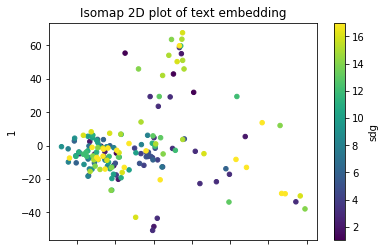

0.8791893491124283 0.0 [[879.18934911 120.81065089]
 [  0.           0.        ]]


C:\Users\GCM\anaconda3\envs\NLP\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ["'", '.', '1', '2', '8', '9', '[', ']'] will be ignored
  warnings.warn(
C:\Users\GCM\anaconda3\envs\NLP\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ["'", '.', '1', '2', '8', '9', '[', ']'] will be ignored
  warnings.warn(
C:\Users\GCM\anaconda3\envs\NLP\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ["'", '.', '1', '2', '8', '9', '[', ']'] will be ignored
  warnings.warn(
C:\Users\GCM\anaconda3\envs\NLP\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ["'", '.', '1', '2', '8', '9', '[', ']'] will be ignored
  warnings.warn(


In [10]:
# use all the data that have targets to estimate accuracy of the 
test_data = data[data['target'].notna()][['abstract', 'target']].iloc[-1000:,:].reset_index(drop=True)

results_df = classify_sdg_target(text_lst=test_data['abstract'].tolist(),
                                 target_data_path='Targets.csv',
                                 run_isomap=True, # run faster for multiple samples otherwise (target_data_path required when this is False) (do not use when only one sample)
                                 target_embedding_reduced_path=None, # load a previously calculated and reduced embedding for the targets 'outputs/targets_embedded_reduced_gpt2_2D.csv'
                                 isomap_dims = 2,
                                 isomap_neigbors = 5, # has to be <= len(text_lst) a.k.a n_samples
                                 pre_trained_model_type='gpt2', 
                                 pre_trained_model_name='gpt2',
                                 target_threshold_val=0.5
                                )

acc = acc_result(true=test_data['target'], pred=results_df['target'])
f1 = f1_macro_result(true=test_data['target'], pred=results_df['target'])
cm = cm_result(true=test_data['target'], pred=results_df['target'])
cm_avg = cm_avg_result(true=test_data['target'], pred=results_df['target'])

print(acc, f1, cm_avg)

In [ ]:
# create sweep for parameter tuning with wandb with evaluation and training fucntions
# modify function to be used for testing both sdg and target classification